In [8]:
# Imports
import glob
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import statsmodels.api as sm
import shutil
import csv
import yaml
from scipy import stats
import math
import datetime as dt

with open('config.yaml') as stream:
    config = yaml.safe_load(stream)


In [9]:
def prepareFolder(path):
    if os.path.exists(path+'/') == True:
        shutil.rmtree(path)
    if os.path.exists(path+'/') == False:
        os.makedirs(path+'/')


In [10]:
# Constants
CAT = {
    'usr': 'total-cpu-usage',
    'sys': 'total-cpu-usage',
    'idl': 'total-cpu-usage',
    'wai': 'total-cpu-usage',
    'hiq': 'total-cpu-usage',
    'siq': 'total-cpu-usage',

    'used': 'memory usage',
    'buff': 'memory usage',
    'cach': 'memory usage',
    'free': 'memory usage',

    'files': 'filesystem',
    'inodes': 'fileystem',

    'read': 'dsk/total',
    'writ': 'dsk/total',
    'reads': 'dsk/total',
    'writs': 'dsk/total',

    'recv': 'net/eth0',
    'send': 'net/eth0',

    'lis': 'tcp sockets',
    'act': 'tcp sockets',
    'syn': 'tcp sockets',
    'tim': 'tcp sockets',
    'clo': 'tcp sockets',

    'tot': 'sockets',
    'tcp': 'sockets',
    'udp': 'sockets',
    'raw': 'sockets',
    'frg': 'sockets',

    'int': 'system',
    'csw': 'system',

    'run': 'procs',
    'blk': 'procs',
    'new': 'procs'
}

CAT_NAMES = ['total-cpu-usage', 'memory-usage', 'filesystem', 'dsk-total1',
             'dsk-total2', 'net-eth0', 'tcp sockets', 'sockets', 'system', 'procs', ]

COL_NAMES_DOCUMENTATION_DO_NOT_DELETE = [
    # total-cpu-usage
    'usr: CPU usage by user processes [%]',
    'sys: CPU usage by system processes [%]',
    'idl: Number of idle processes [#]',
    'wai: Number of waiting processes [#]',
    'hiq: Number of hard interrupts [#]',
    'siq: Number of soft interrupts [#]',
    # memory usage
    # https://www.tecmint.com/dstat-monitor-linux-server-performance-process-memory-network/
    # https://linuxtect.com/linux-dstat-command-monitor-linux-performance-and-resource-usage/
    # https://www.thegeekdiary.com/understanding-proc-meminfo-file-analyzing-memory-utilization-in-linux/
    # /proc/meminfo
    'used: Amount of used memory [Bytes]',  # / 1024 = KB
    'buff: Amount of buffered memory [Bytes]',  # / 1024 / 1024 = MB
    'cach: Amount of cached memory [Bytes]',
    'free: Amount of free memory [Bytes]',

    # filesystem
    # https://www.linuxquestions.org/questions/linux-general-1/proc-sys-fs-file-nr-57646/
    # /proc/sys/fs/file-nr
    'files: Number of allocated file handles [#]',
    'inodes: Number of used file handles [#]',

    # dsk/total
    'read: Amount of read bytes on disk [Bytes]',  # not 100% sure
    'writ: Amount of written bytes on disk [Bytes]',  # / 1024 = KB

    # dsk/total
    'reads: Number of read operations on disk [#]',
    'writs: Number of write operations on disk [#]',

    # net/eth0
    'recv: Amount of received bytes on eth0 [B]',  # /1024 = k
    'send: Amount of received bytes on eth0 [B]',

    # tcp sockets
    # http://karunsubramanian.com/network/what-is-syn_sent-socket-status/
    # /proc/net/tcp
    # /proc/net/tcp6
    'lis: Number of TCP connections with status "listening" [#]',
    'act: Number of TCP connections with status "established" (active) [#]',
    'syn: Number of TCP connections with status "syn_sent", "syn_receive" or "last_ack" [#]',
    'tim: Number of TCP connections with status "waiting"[#]',
    'clo: Number of TCP connections with status "fin-wait1/2", "close/_wait" or "closign" (closed) [#]',

    # sockets
    # https://community.hpe.com/t5/Networking/Regarding-meaning-for-quot-cat-proc-net-sockstat-quot-results/td-p/3922867#.Yvnld3VBxhE
    # /proc/net/sockstat
    'tot: Number of total sockets [#]',
    'tcp: Number of tcp sockets [#]',
    'udp: Number of udp sockets [#]',
    'raw: Number of raw (using no protocol) sockets [#]',
    'frg: Number of frag sockets [#]',

    # system
    # https://www.tecmint.com/dstat-monitor-linux-server-performance-process-memory-network/
    'int: Number of interrupts [#]',
    'csw: Number of ontext switches [#]',

    # procs
    # /proc/stat
    'run: Number of processes with status "running" [#]',
    'blk: Number of processes with status "blocked" [#]',
    'new: Number of processes with status "new" [#]'
]

COL_NAMES = [
    # total-cpu-usage
    'usr: CPU usage by user processes [%]',
    'sys: CPU usage by system processes [%]',
    'idl: Number of idle processes [#]',
    'wai: Number of waiting processes [#]',
    'hiq: Number of hard interrupts [#]',
    'siq: Number of soft interrupts [#]',
    # memory usage
    # https://www.tecmint.com/dstat-monitor-linux-server-performance-process-memory-network/
    # https://linuxtect.com/linux-dstat-command-monitor-linux-performance-and-resource-usage/
    # https://www.thegeekdiary.com/understanding-proc-meminfo-file-analyzing-memory-utilization-in-linux/
    # /proc/meminfo
    'used: Amount of used memory [Bytes]',  # / 1024 = KB
    'buff: Amount of buffered memory [Bytes]',  # / 1024 / 1024 = MB
    'cach: Amount of cached memory [Bytes]',
    'free: Amount of free memory [Bytes]',

    # filesystem
    # https://www.linuxquestions.org/questions/linux-general-1/proc-sys-fs-file-nr-57646/
    # /proc/sys/fs/file-nr
    'files: Number of allocated file handles [#]',
    'inodes: Number of used file handles [#]',

    # dsk/total
    'read: Amount of read bytes on disk [Bytes]',  # not 100% sure
    'writ: Amount of written bytes on disk [Bytes]',  # / 1024 = KB

    # dsk/total
    'reads: Number of read operations on disk [#]',
    'writs: Number of write operations on disk [#]',

    # net/eth0
    'recv: Amount of received bytes on eth0 [B]',  # /1024 = k
    'send: Amount of received bytes on eth0 [B]',

    # tcp sockets
    # http://karunsubramanian.com/network/what-is-syn_sent-socket-status/
    # /proc/net/tcp
    # /proc/net/tcp6
    'lis: Number of TCP connections "listening" [#]',
    'act: Number of TCP connections "established" (active) [#]',
    'syn: Number of TCP connections "syn_s", "syn_r" or "last_a" [#]',
    'tim: Number of TCP connections with status "waiting"[#]',
    'clo: Number of TCP connections with status "closing"  [#]',

    # sockets
    # https://community.hpe.com/t5/Networking/Regarding-meaning-for-quot-cat-proc-net-sockstat-quot-results/td-p/3922867#.Yvnld3VBxhE
    # /proc/net/sockstat
    'tot: Number of total sockets [#]',
    'tcp: Number of tcp sockets [#]',
    'udp: Number of udp sockets [#]',
    'raw: Number of raw sockets [#]',
    'frg: Number of frag sockets [#]',

    # system
    # https://www.tecmint.com/dstat-monitor-linux-server-performance-process-memory-network/
    'int: Number of interrupts [#]',
    'csw: Number of ontext switches [#]',

    # procs
    # /proc/stat
    'run: Number of processes with status "running" [#]',
    'blk: Number of processes with status "blocked" [#]',
    'new: Number of processes with status "new" [#]'
]


In [11]:
from df_loader import main

dfs, names = main()
# sanity check
for (df, name) in zip(dfs, names):
    print(df['usr'].iloc[0], name)


2.647 05 bashlite


In [12]:
for (df, name) in zip(dfs, names):
    print(df.index[120])
    print(df.index[240])


2022-08-28 15:23:02
2022-08-28 15:25:02


In [13]:
mtd_tp_list = [
    '2022-08-28 08:35:39', # beurk
    #'', # bashlite # no MTD!
    '2022-08-28 15:52:10', # bdvl
    '2022-08-28 15:35:55', # backdoor
    '2022-08-28 09:14:32', # ransomware
    '2022-08-28 09:54:47', # thetick
    '2022-08-28 09:27:54', # httpbackdoor
]

/tmp/ipykernel_18232/643780691.py:50: UserWarning: 'set_params()' not defined for locator of type <class 'pandas.plotting._matplotlib.converter.TimeSeries_DateLocator'>
  plt.locator_params(axis='x', nbins=10)
/tmp/ipykernel_18232/643780691.py:77: UserWarning: 'set_params()' not defined for locator of type <class 'pandas.plotting._matplotlib.converter.TimeSeries_DateLocator'>
  plt.locator_params(axis='x', nbins=10)
/tmp/ipykernel_18232/643780691.py:98: UserWarning: 'set_params()' not defined for locator of type <class 'pandas.plotting._matplotlib.converter.TimeSeries_DateLocator'>
  plt.locator_params(axis='x', nbins=10)
/tmp/ipykernel_18232/643780691.py:122: UserWarning: 'set_params()' not defined for locator of type <class 'pandas.plotting._matplotlib.converter.TimeSeries_DateLocator'>
  plt.locator_params(axis='x', nbins=10)
/tmp/ipykernel_18232/643780691.py:50: UserWarning: 'set_params()' not defined for locator of type <class 'pandas.plotting._matplotlib.converter.TimeSeries_Date

IndexError: list index out of range

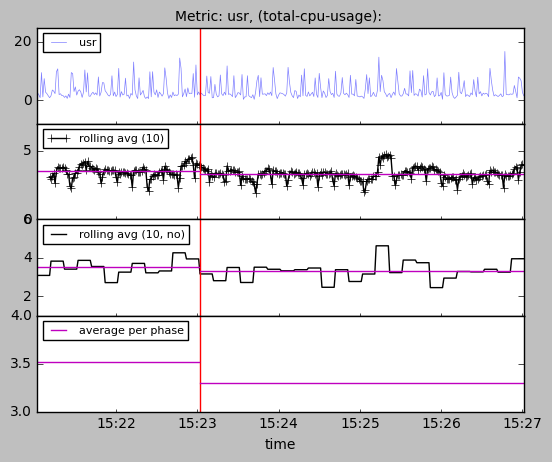

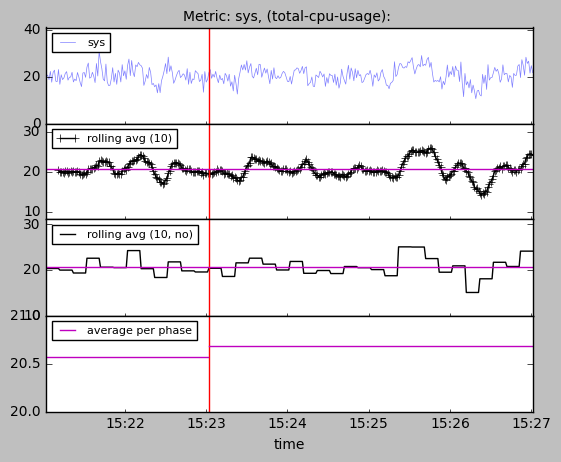

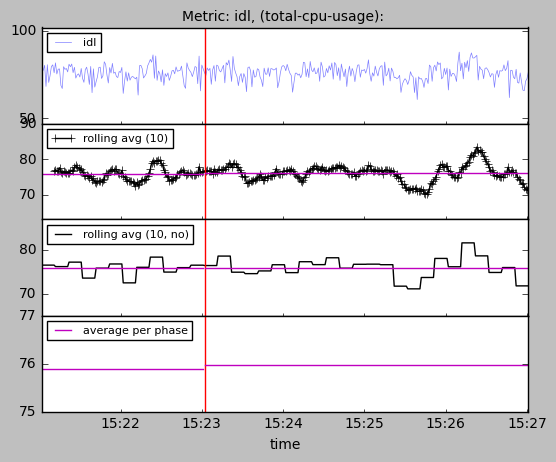

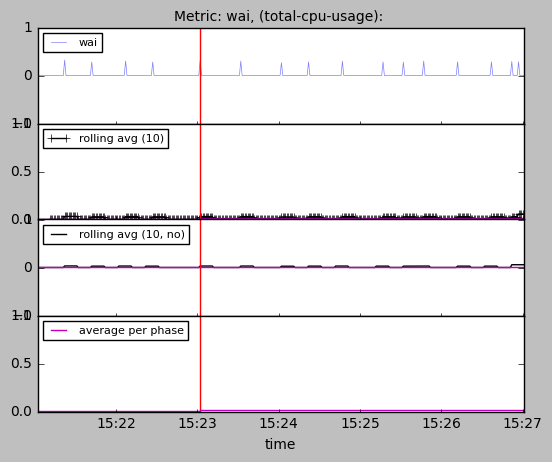

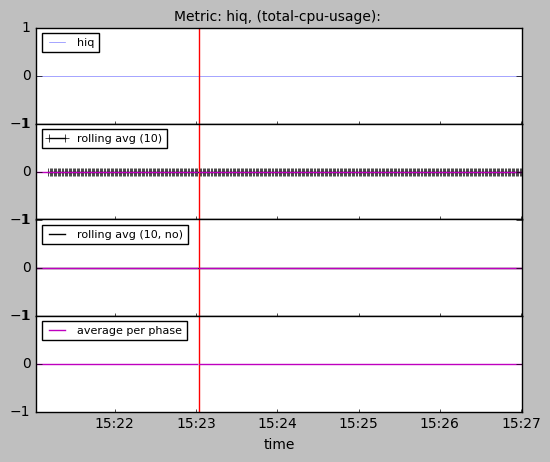

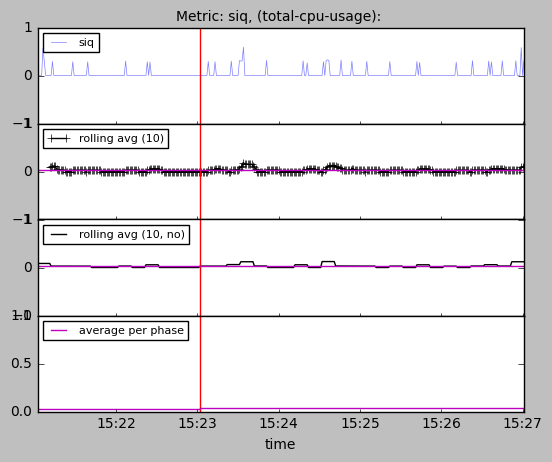

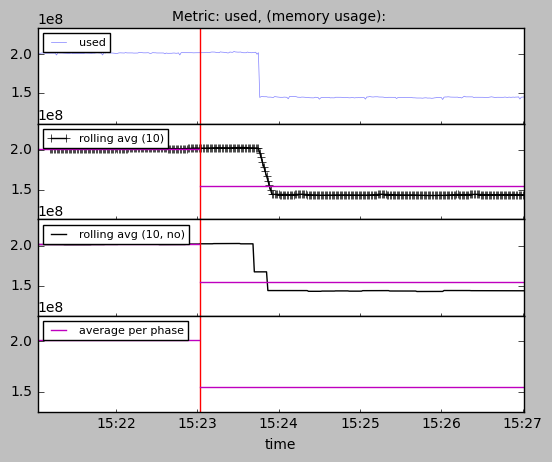

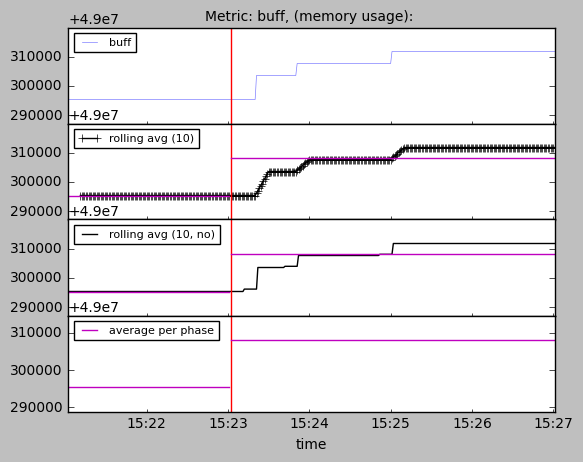

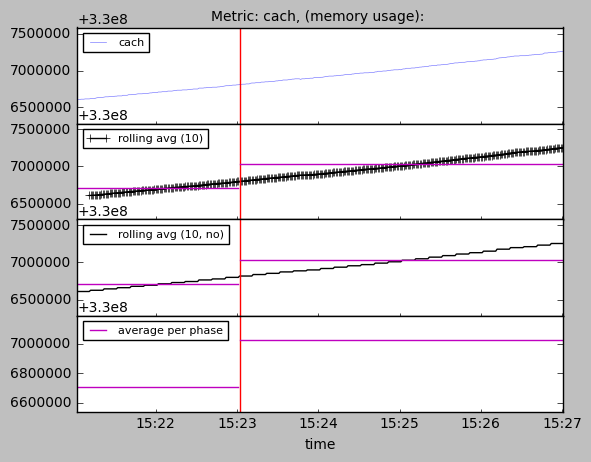

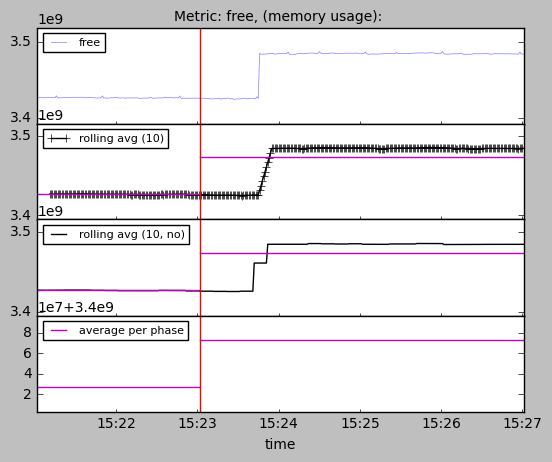

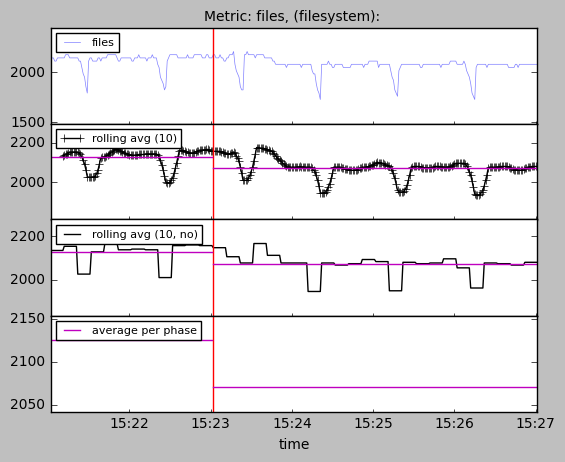

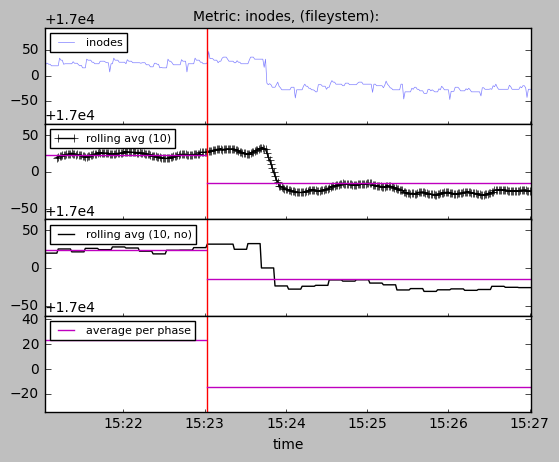

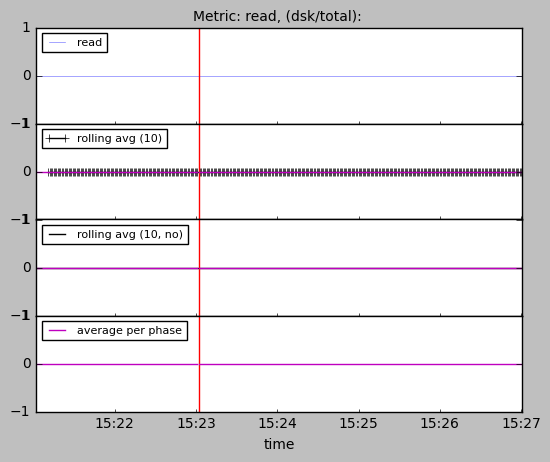

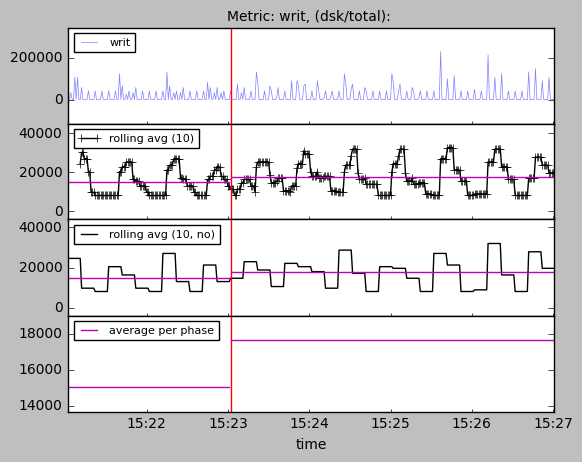

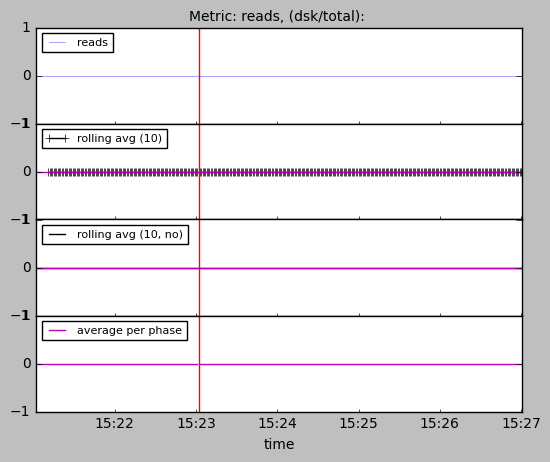

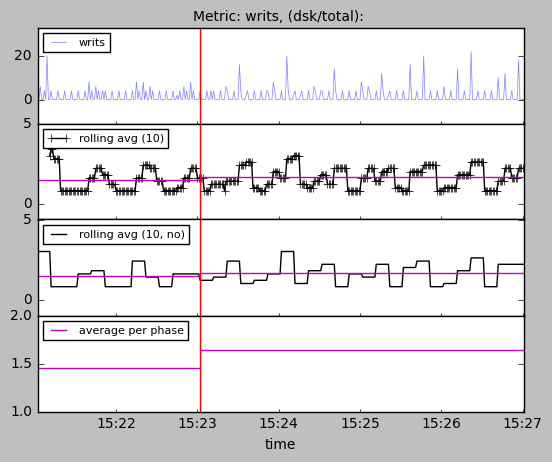

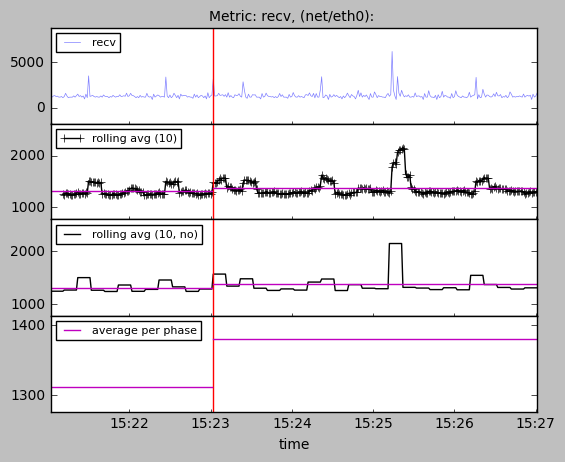

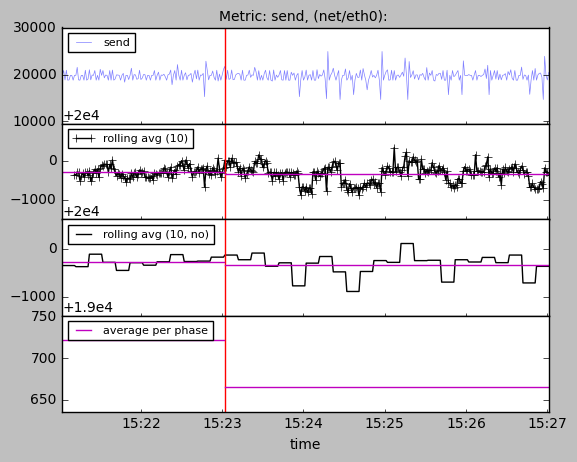

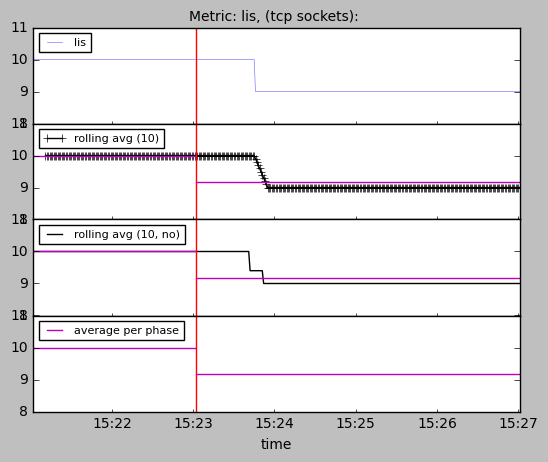

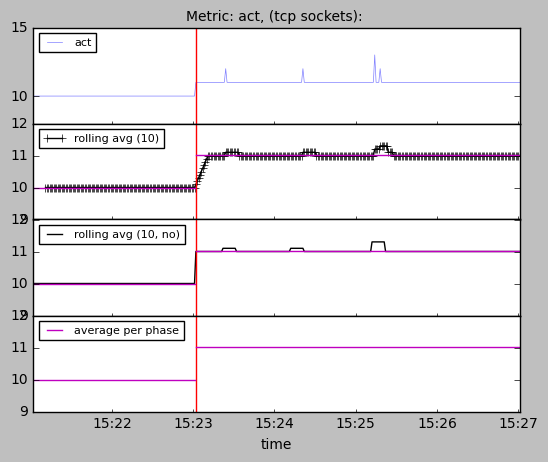

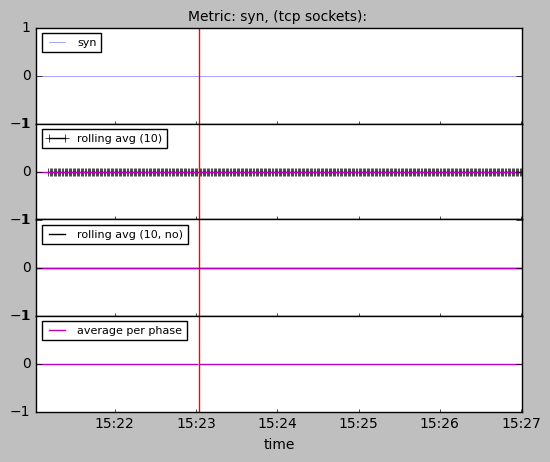

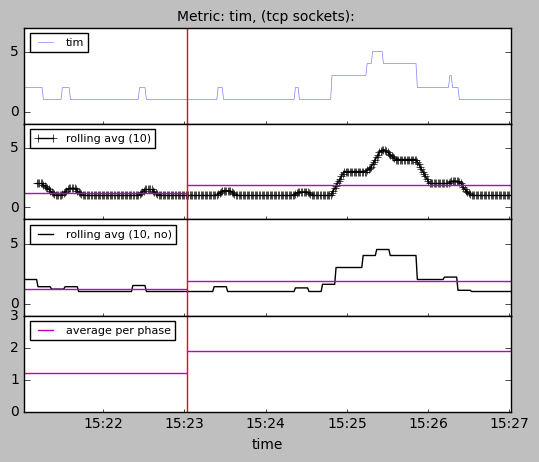

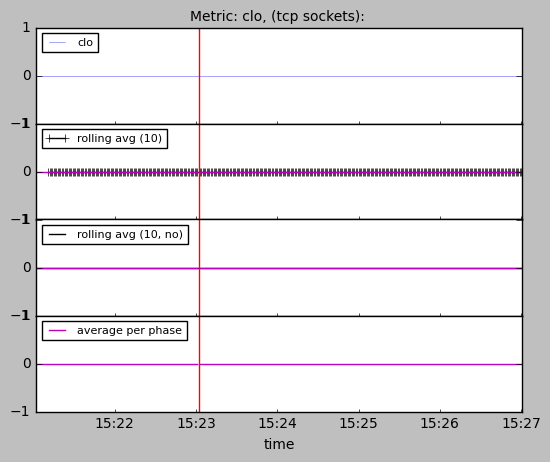

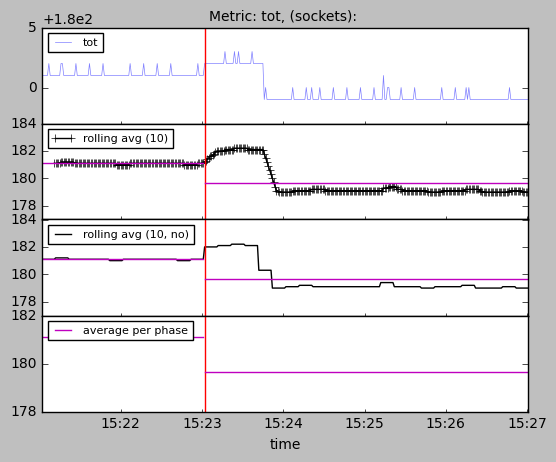

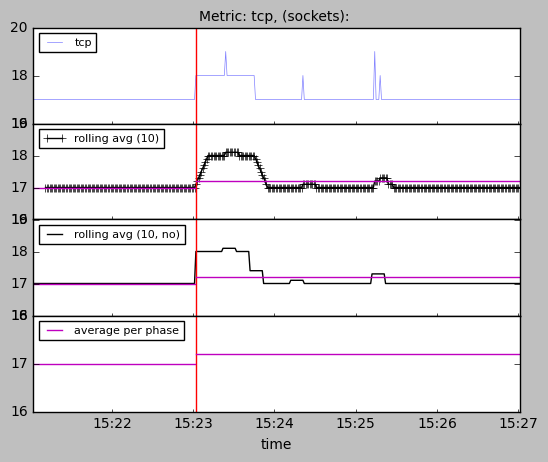

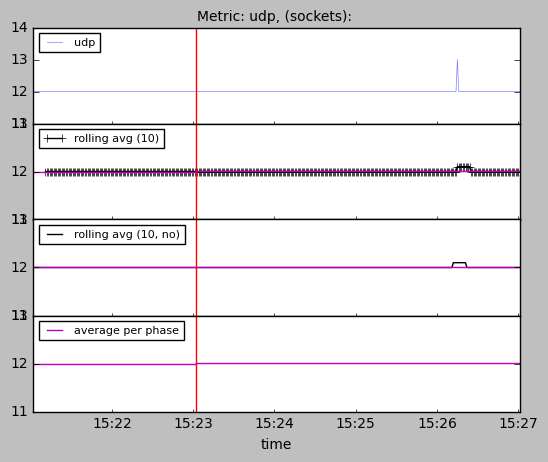

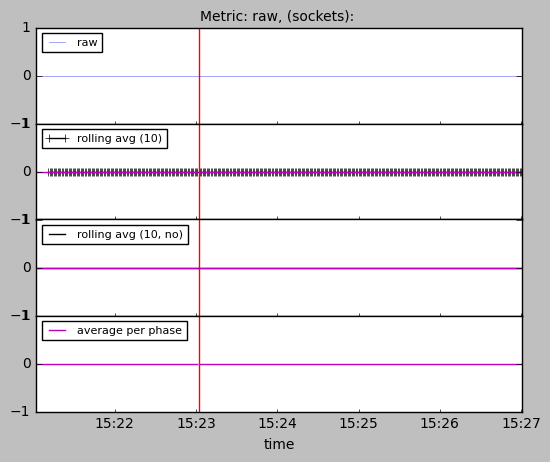

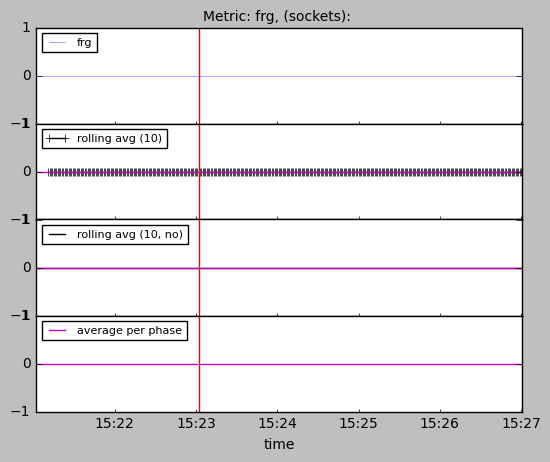

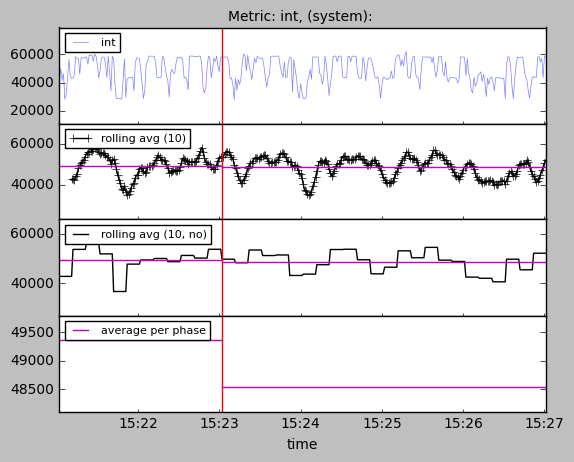

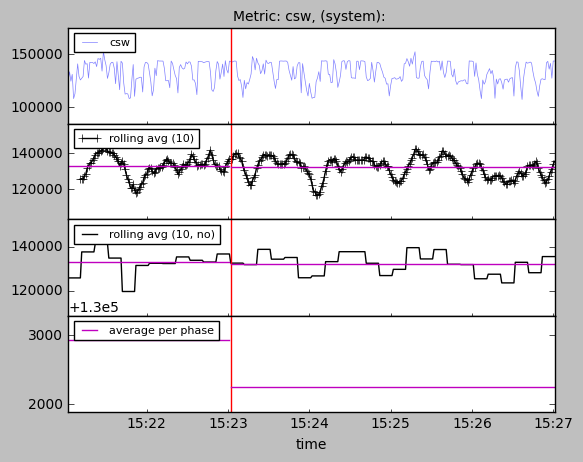

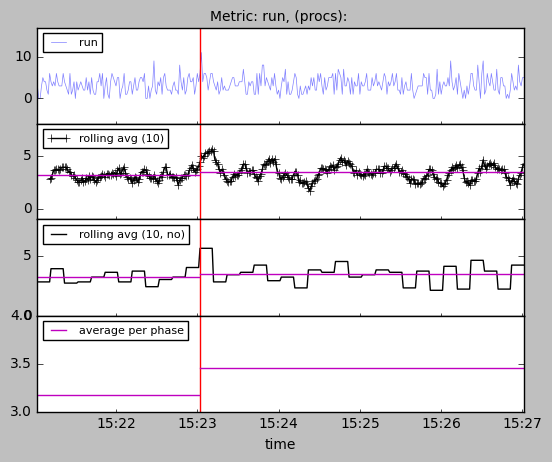

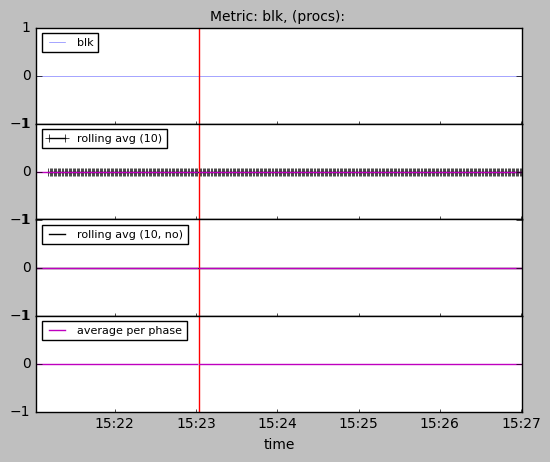

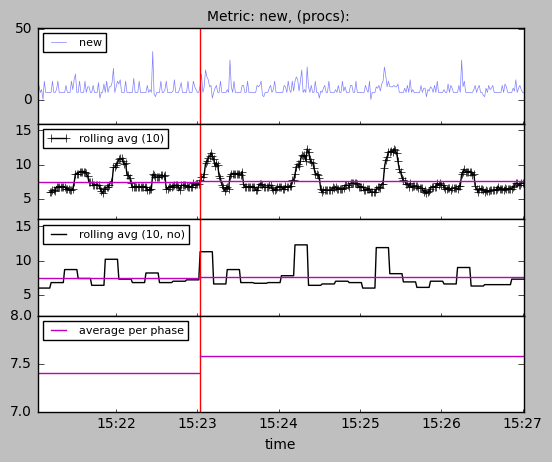

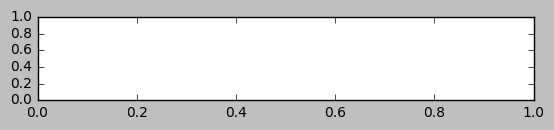

In [15]:
# Time Series
prepareFolder('plots/timeseries')
plt.style.use('classic')

plt.rc('font', size=10) #controls default text size
plt.rc('axes', titlesize=10) #fontsize of the title
plt.rc('axes', labelsize=10) #fontsize of the x and y labels
plt.rc('xtick', labelsize=10) #fontsize of the x tick labels
plt.rc('ytick', labelsize=10) #fontsize of the y tick labels
plt.rc('legend', fontsize=8) #fontsize of the legend




for (df, name) in zip(dfs, names):
    start = df.index[0]
    # print(df.index[0])
    os.mkdir('plots/timeseries/'+name)
    index = 0

    for column in df.columns:
        # print(column)
        fig = plt.figure(figsize=(6.4, 4.8), dpi=100)
        df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]  # remove outliers

        # calculate average
        df[column+'-avg-healthy'] = df[column].iloc[:120].mean()
        df[column+'-avg-infected'] = df[column].iloc[120:].mean()
        
        df[column+'-rolling-avg'] = df[column].rolling(10).mean()
        df[column+'-rolling-non-overlapping-avg'] = df[column].rolling(10).mean()[
            10-1::10]
        df[column+'-rolling-non-overlapping-avg'].bfill(inplace=True)

        
        ax1 = plt.subplot(411)
        ax1 = df[column].plot(color='C0',
                              alpha=0.5, linewidth=0.5, label=COL_NAMES[index].split(':')[0])
        ax1 = plt.axvline(df.index[120], color='C2')  # triggering malware

        upperBound = df[column].max()
        lowerBound = df[column].min()
        if float(lowerBound) == 0 and float(upperBound) == 0:
            ax1 = plt.ylim(bottom=-1, top=1)
        else:
            ax1 = plt.ylim(bottom=math.floor(lowerBound-0.5*(upperBound-lowerBound)),
                           top=math.ceil(upperBound+0.5*(upperBound-lowerBound)))
        plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=False)
        plt.locator_params(axis='y', nbins=3)
        plt.locator_params(axis='x', nbins=10)
        plt.title('Metric: {}, ({}): '.format(column, CAT.get(column)))
        plt.legend(loc='upper left')
        

        ax2 = plt.subplot(412)
        ax2 = df[column+'-rolling-avg'].plot(marker="+", color='C6',
                                             alpha=1, linewidth=1, label='rolling avg (10)')
        ax2 = plt.axvline(df.index[120], color='C2')  # triggering malware
        ax2 = df[column+'-avg-healthy'].iloc[:120].plot(
            color='C4', alpha=1, linestyle='-', linewidth=1, label='')
        ax2 = df[column+'-avg-infected'].iloc[120:].plot(
            color='C4', alpha=1, linestyle='-', linewidth=1, label='')
        
        upperBound = df[column+'-rolling-avg'].max()
        # first 9 values are NAN
        lowerBound = np.nanmin(
            df[column+'-rolling-avg'].replace(0, np.nan).values)
        if math.isnan(float(lowerBound)):
            ax2 = plt.ylim(bottom=-1, top=1)
        elif float(lowerBound) == 0 and float(upperBound) == 0:
            ax2 = plt.ylim(bottom=-1, top=1)
        else:
            ax2 = plt.ylim(bottom=math.floor(lowerBound-0.5*(upperBound-lowerBound)),
                           top=math.ceil(upperBound+0.5*(upperBound-lowerBound)))
        plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=False)
        plt.locator_params(axis='y', nbins=3)
        plt.locator_params(axis='x', nbins=10)
        plt.legend(loc='upper left')

        ax3 = plt.subplot(413)
        ax3 = df[column+'-rolling-non-overlapping-avg'].plot(
            color='C6', alpha=1, linewidth=1, label='rolling avg (10, no)')
        ax3 = plt.axvline(df.index[120], color='C2')  # triggering malware
        ax3 = df[column+'-avg-healthy'].iloc[:120].plot(
            color='C4', alpha=1, linestyle='-', linewidth=1, label='')
        ax3 = df[column+'-avg-infected'].iloc[120:].plot(
            color='C4', alpha=1, linestyle='-', linewidth=1, label='')

        upperBound = df[column+'-rolling-non-overlapping-avg'].max()
        lowerBound = df[column+'-rolling-non-overlapping-avg'].min()
        if float(lowerBound) == 0 and float(upperBound) == 0:
            ax3 = plt.ylim(bottom=-1, top=1)
        else:
            ax3 = plt.ylim(bottom=math.floor(lowerBound-0.5*(upperBound-lowerBound)),
                           top=math.ceil(upperBound+0.5*(upperBound-lowerBound)))
        plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=False)
        plt.locator_params(axis='y', nbins=3)
        plt.locator_params(axis='x', nbins=10)
        plt.legend(loc='upper left')

        ax4 = plt.subplot(414)
        ax4 = df[column].plot(color='C1', alpha=0, linewidth=0, label='') # leave dummy for x ticks
        ax4 = plt.axvline(df.index[120], color='C2')  # triggering malware
        ax4 = df[column+'-avg-healthy'].iloc[:120].plot(
            color='C4', alpha=1, linestyle='-', linewidth=1, label='average per phase')
        ax4 = df[column+'-avg-infected'].iloc[120:].plot(
            color='C4', alpha=1, linestyle='-', linewidth=1, label='')

        # adjust y axis
        upperBound = max([df[column+'-avg-healthy'].max(),
                         df[column+'-avg-infected'].max()])
        lowerBound = min([df[column+'-avg-healthy'].min(),
                         df[column+'-avg-infected'].min()])

        if float(lowerBound) == 0 and float(upperBound) == 0:
            ax4 = plt.ylim(bottom=-1, top=1)
        else:
            ax4 = plt.ylim(bottom=math.floor(lowerBound-0.5*(upperBound-lowerBound)),
                           top=math.ceil(upperBound+0.5*(upperBound-lowerBound)))
        plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
        plt.locator_params(axis='y', nbins=3)
        plt.locator_params(axis='x', nbins=10)
        plt.legend(loc='upper left')

        fig.subplots_adjust(hspace=0, left=0.14, right=0.90)
        plt.setp([a.get_xticklabels() for a in fig.axes[:-1]], visible=True)
        # shared legend
        '''
        lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
        lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
        fig.legend(lines, labels)
        '''

        plt.savefig('plots/timeseries/{}/{}-timeseries.png'.format(name, column),
                    facecolor='white', transparent=False, bbox_inches="tight")
        index += 1
    plt.cla()
plt.close('all')
